In [101]:
import kagglehub
import numpy as np
import polars as pl
import seaborn as sns
from typing import Tuple
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Data Preparation

In [102]:
# Download latest version
path = kagglehub.dataset_download("nikhil7280/student-performance-multiple-linear-regression")

print("Path to dataset files:", path)

Path to dataset files: D:\SISTEMA\WinUsers\Irene\.cache\kagglehub\datasets\nikhil7280\student-performance-multiple-linear-regression\versions\1


In [103]:
file_path = path + "\\" + "Student_Performance.csv"
df_original = pl.read_csv(source=file_path, separator=",", ignore_errors=True)
df_original.head(15)

Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
i64,i64,str,i64,i64,f64
7,99,"""Yes""",9,1,91.0
4,82,"""No""",4,2,65.0
8,51,"""Yes""",7,2,45.0
5,52,"""Yes""",5,2,36.0
7,75,"""No""",8,5,66.0
3,78,"""No""",9,6,61.0
7,73,"""Yes""",5,6,63.0
8,45,"""Yes""",4,6,42.0
5,77,"""No""",8,2,61.0


In [104]:
print(f"This dataset has {len(df_original)} rows.")

This dataset has 10000 rows.


In [105]:
# Convert the column "Extracurricular Activities" to integer.
# We could use Label Encoder, but in this case, as it is only two categories, I will use a dictionary.

extra_act_dict = {"Yes": 1, "No": 0}
df = df_original.with_columns(pl.col("Extracurricular Activities").replace(extra_act_dict).str.to_integer())
df.head(5)

Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
i64,i64,i64,i64,i64,f64
7,99,1,9,1,91.0
4,82,0,4,2,65.0
8,51,1,7,2,45.0
5,52,1,5,2,36.0
7,75,0,8,5,66.0


In [106]:
# Check if any column has null values
df.describe()

statistic,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
str,f64,f64,f64,f64,f64,f64
"""count""",10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",4.9929,69.4457,0.4948,6.5306,4.5833,55.2248
"""std""",2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
"""min""",1.0,40.0,0.0,4.0,0.0,10.0
"""25%""",3.0,54.0,0.0,5.0,2.0,40.0
"""50%""",5.0,69.0,0.0,7.0,5.0,55.0
"""75%""",7.0,85.0,1.0,8.0,7.0,71.0
"""max""",9.0,99.0,1.0,9.0,9.0,100.0


As we can observe, it has not null values.

### Explore Correlation

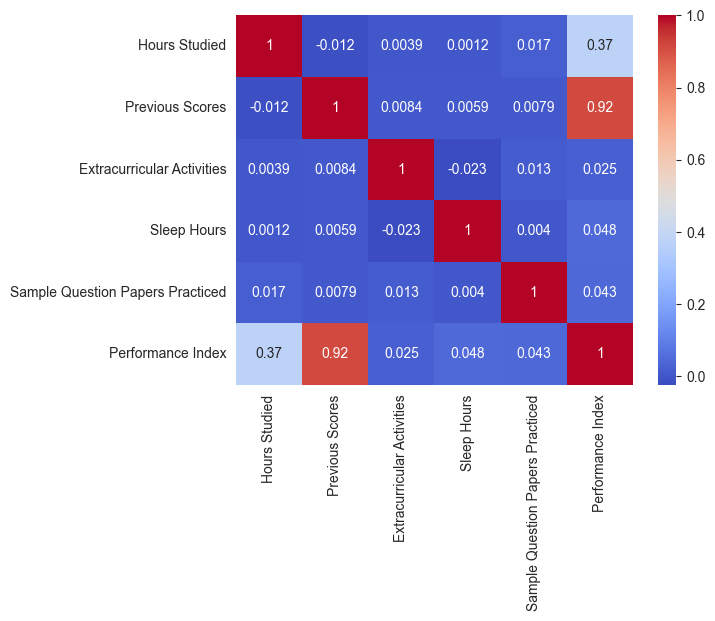

In [107]:
#f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', xticklabels=df.columns, yticklabels=df.columns)
plt.show()

The columns "Previous Scores" and "Hours Studies" are the ones more correlated with the dependent variable "Performance Index"

### Check Outliers

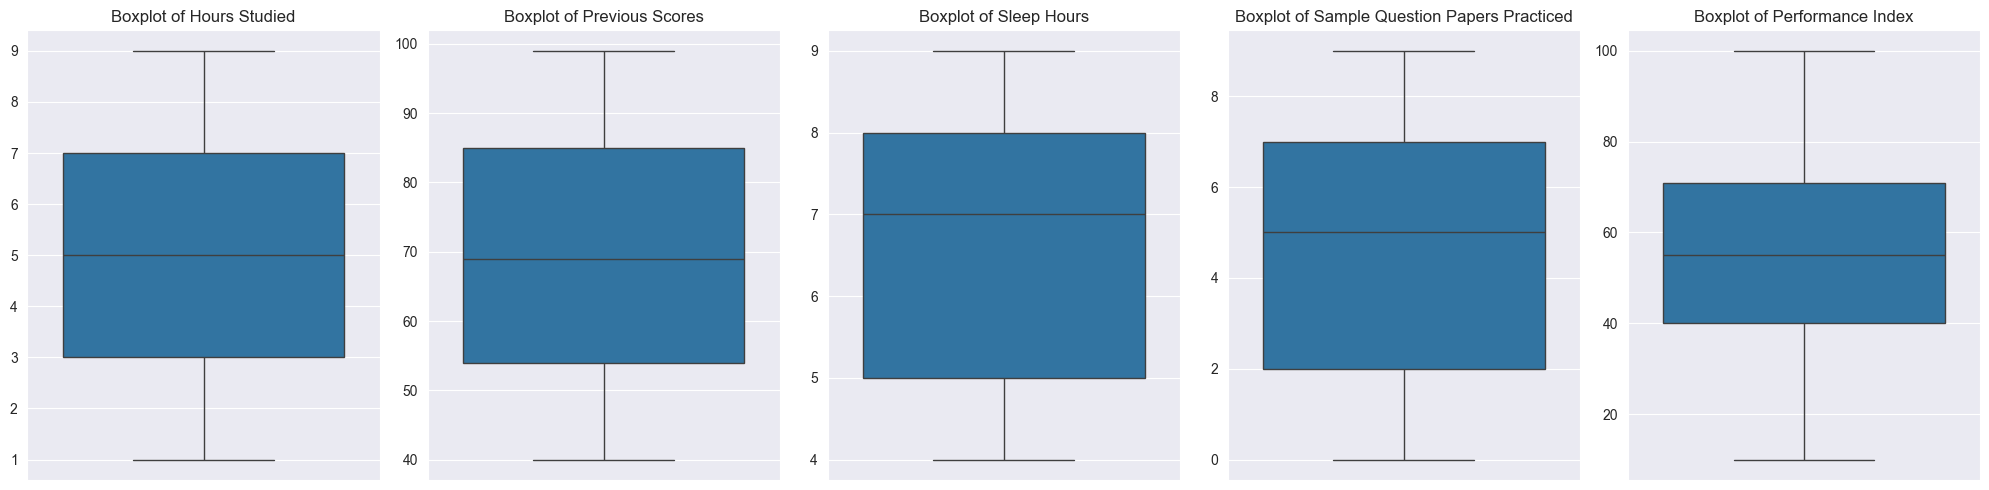

In [108]:
columns = df.columns
columns.remove("Extracurricular Activities")

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
sns.set_style("darkgrid")

for i, column in enumerate(columns):
    sns.boxplot(data=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

The boxplots show no outliers, so there is no need to remove them.

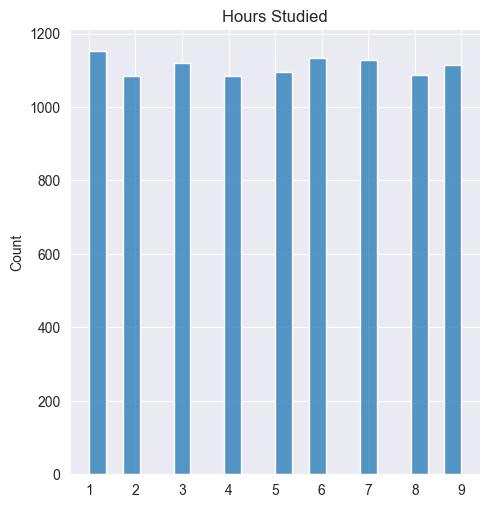

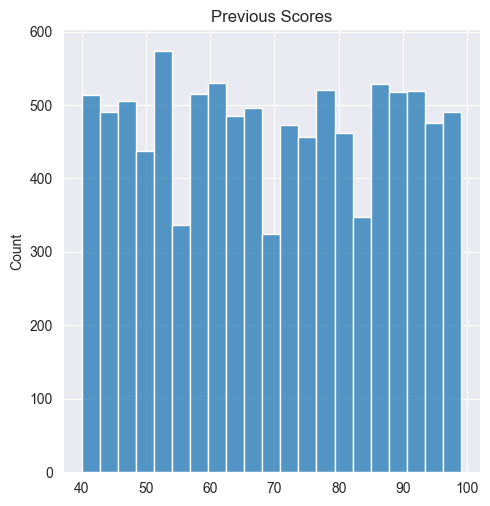

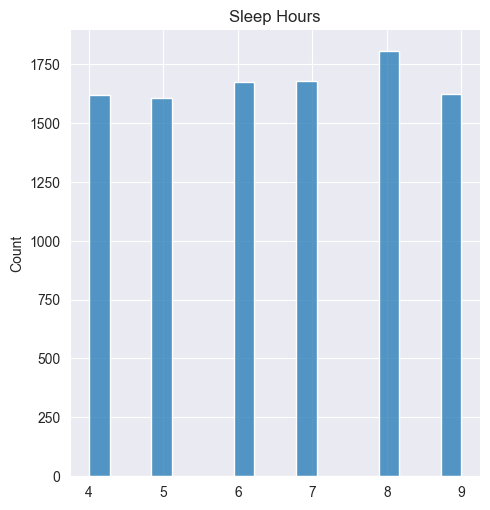

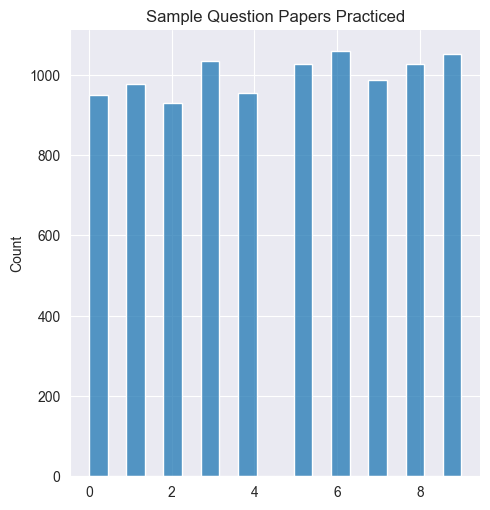

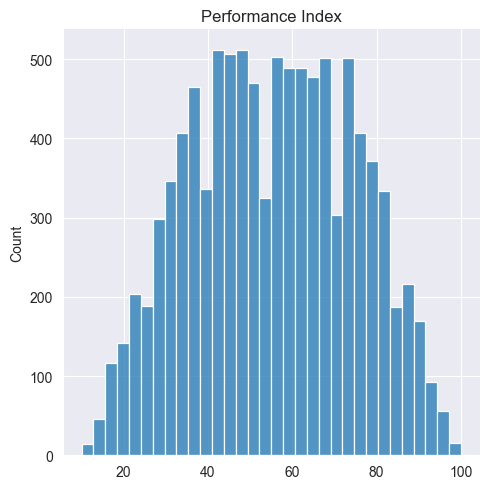

In [109]:
columns = df.columns
columns.remove("Extracurricular Activities")

sns.set_style("darkgrid")

for i, column in enumerate(columns):
    sns.displot(data=df[column]).set(title=f"{column}")

plt.tight_layout()
plt.show()

## Multiple Linear Regression (MLR)

### Train-Test Split

In [110]:
y = df["Performance Index"].to_list()
x = df.drop("Performance Index")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=101)

### Train Model

In [111]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [112]:
# Obtain Predictions
preds = lr.predict(x_test)

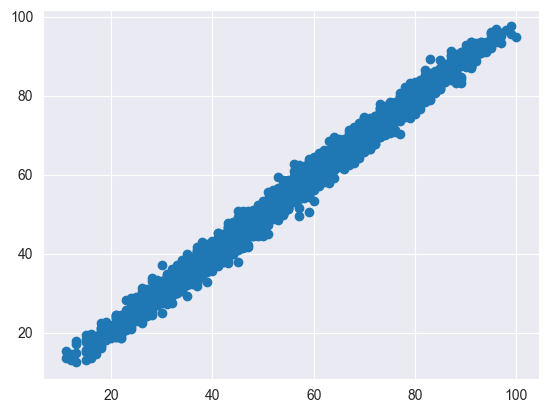

In [113]:
plt.scatter(y_test,preds)

In [114]:
print('MAE:', round(metrics.mean_absolute_error(y_test, preds), 5))
print('MSE:', round(metrics.mean_squared_error(y_test, preds), 5))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, preds)), 5))
print("R2 score =", round(metrics.r2_score(y_test, preds), 5))

MAE: 1.60355
MSE: 4.0796
RMSE: 2.0198
R2 score = 0.98883


</b>

### Try Normalizing the data

In [115]:
from sklearn.preprocessing import MinMaxScaler

apply_MinMaxScaler = True

if apply_MinMaxScaler:
    scaler = MinMaxScaler()
    columns_to_scale = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
    x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
x_train

Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
f64,f64,i64,f64,f64
0.5,0.661017,1,0.0,0.666667
0.25,0.220339,1,0.4,0.777778
0.125,0.40678,1,0.4,1.0
1.0,0.016949,0,1.0,0.444444
0.625,0.59322,1,0.6,0.0
0.0,0.389831,1,0.8,0.333333
0.375,0.627119,1,0.4,0.555556
0.875,0.745763,0,1.0,0.222222
0.875,0.220339,0,0.2,0.111111


In [116]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [117]:
if apply_MinMaxScaler:
    x_test[columns_to_scale] = scaler.transform(x_test[columns_to_scale])

In [118]:
preds = lr.predict(x_test)

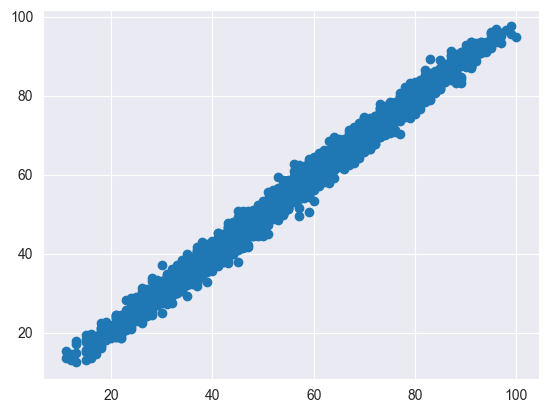

In [119]:
plt.scatter(y_test,preds)

In [120]:
print('MAE:', round(metrics.mean_absolute_error(y_test, preds), 5))
print('MSE:', round(metrics.mean_squared_error(y_test, preds), 5))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, preds)), 5))
print("R2 score =", round(metrics.r2_score(y_test, preds), 5))

MAE: 1.60355
MSE: 4.0796
RMSE: 2.0198
R2 score = 0.98883
